# Oral Cancer Classification

## Train Test Split

In [1]:
import os
import shutil
import pathlib
import random

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.utils import image_dataset_from_directory

import matplotlib.pyplot as plt

import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy.ndimage

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications import VGG16

2024-09-28 17:18:00.448839: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-28 17:18:00.814656: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-28 17:18:01.556883: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
original_dir = pathlib.Path("Content_3class_new")
new_base_dir = pathlib.Path("oral_cancer_train_test_split")

def make_subset(subset_name, categories):
    for category, (start_index, end_index) in categories.items():
        dir = new_base_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)

        for i in range(start_index, end_index):
            for ext in ['.jpg', '.jpeg', '.png']:
                fname = f"{category}.{i}{ext}"
                src = original_dir / category/ fname
                if src.exists(): 
                    shutil.copy(src, dir / fname)
                    break

In [1]:
# images in each category
categories = {
    "normal": (0, 213),      # 80% of 266 for training
    "pre_cancer": (0, 249),   # 80% of 312 for training
    "oral_cancer": (0, 226),      # 80% of 283 for training
}

# training set
make_subset("train", categories)

# categories for testing
categories = {
    "normal": (213, 266),    # Remaining 20% for testing
    "pre_cancer": (249, 312),  # Remaining 20% for testing
    "oral_cancer": (226, 283),     # Remaining 20% for testing
}

# testing set
make_subset("test", categories)

print('Created training and testing subsets')

Created training and testing subsets


## CNN Model

In [4]:
# model
inputs = keras.Input(shape=(224, 224, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Dropout(0.5)(x)  # reduce overfitting
x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)  # regularization
outputs = layers.Dense(3, activation="softmax")(x)  # softmax for multi-class

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use sparse_categorical_crossentropy for integer labels
              metrics=['accuracy'])

model.summary()

2024-09-18 11:00:24.786889: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,718,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,107,523 (19.48 MB)

 Trainable params: 5,107,523 (19.48 MB)

 Non-trainable params: 0 (0.00 B)

## Preprocessing

In [14]:
# read dataset
train_dataset = image_dataset_from_directory(new_base_dir / "train", image_size=(224, 224), batch_size=32)
test_dataset = image_dataset_from_directory(new_base_dir / "test", image_size=(224, 224), batch_size=32)

for data_batch, labels_batch in train_dataset:
    print("Data batch shape:", data_batch.shape)
    print("Labels batch shape:", labels_batch.shape)
    break

Found 685 files belonging to 3 classes.
Found 173 files belonging to 3 classes.
Data batch shape: (32, 224, 224, 3)
Labels batch shape: (32,)


## Train CNN

In [6]:
# fit model
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="cnn.keras", save_best_only=True, monitor="val_loss") ]

history = model.fit( train_dataset, epochs=10, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/10


2024-09-18 11:00:33.100397: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:34.460565: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.



 1/22 ━━━━━━━━━━━━━━━━━━━━ 1:05 3s/step - accuracy: 0.2500 - loss: 1.1055

2024-09-18 11:00:34.829210: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.
2024-09-18 11:00:36.180299: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.



 2/22 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2656 - loss: 1.2350 

2024-09-18 11:00:36.526573: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 201867264 exceeds 10% of free system memory.


22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.3321 - loss: 1.1781 - val_accuracy: 0.3179 - val_loss: 1.0954
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.3566 - loss: 1.0935 - val_accuracy: 0.3526 - val_loss: 1.0578
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.3244 - loss: 1.0861 - val_accuracy: 0.4451 - val_loss: 1.1005
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4513 - loss: 1.0434 - val_accuracy: 0.3295 - val_loss: 1.1433
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.4438 - loss: 1.0472 - val_accuracy: 0.3410 - val_loss: 1.1250
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.4422 - loss: 1.0223 - val_accuracy: 0.4277 - val_loss: 1.1851
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5650 - loss: 0.8805 - val_accuracy: 0.4566 - val_loss: 1.0392
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.5625 - loss: 0.8722 - val_accuracy: 0.5145 - val_loss: 0.9942
Epo

In [9]:
history2 = model.fit( train_dataset, epochs=5, validation_data=test_dataset, callbacks=callbacks)

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6125 - loss: 0.7162 - val_accuracy: 0.5549 - val_loss: 0.9023
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.7013 - loss: 0.6506 - val_accuracy: 0.5376 - val_loss: 0.9077
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6551 - loss: 0.6704 - val_accuracy: 0.5087 - val_loss: 0.9290
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 75s 2s/step - accuracy: 0.6805 - loss: 0.6089 - val_accuracy: 0.5260 - val_loss: 0.9459
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6912 - loss: 0.5744 - val_accuracy: 0.5202 - val_loss: 0.8856


In [15]:
def plot_training_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    
    epochs = range(1, len(accuracy) + 1)

    # accuracy
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

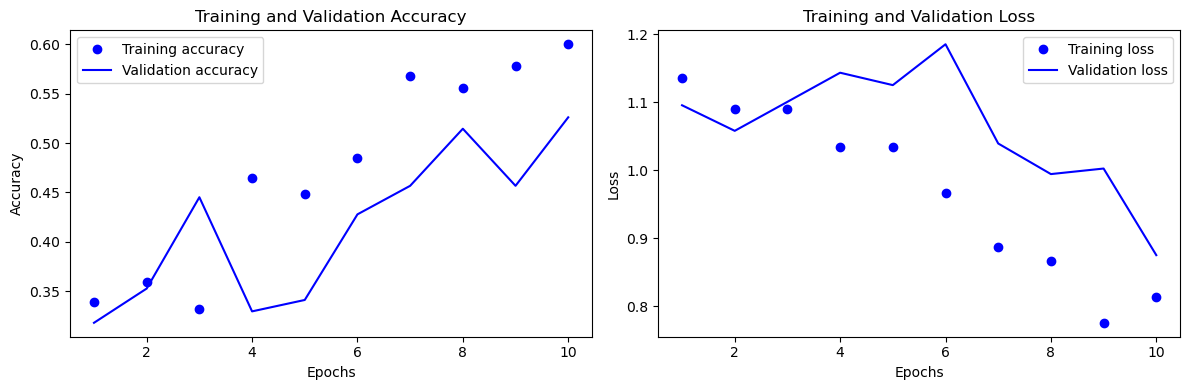

In [8]:
plot_training_history(history)

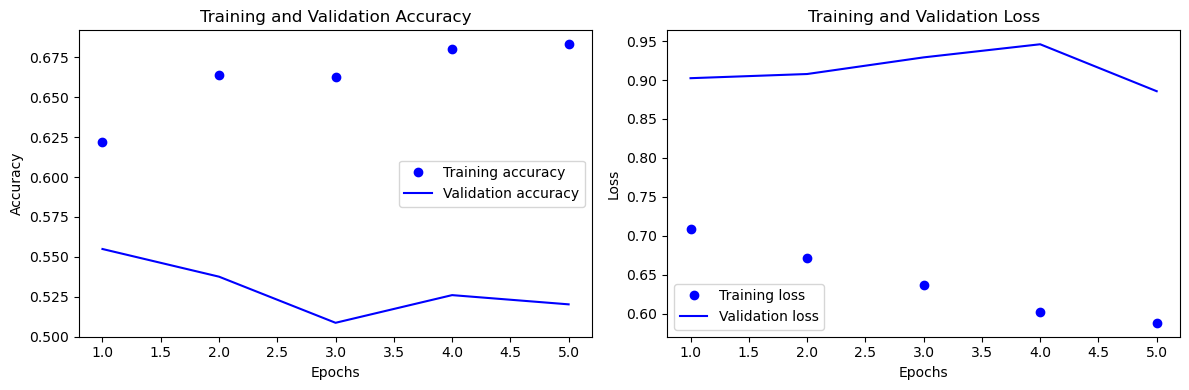

In [10]:
plot_training_history(history2)

In [42]:
test_model = keras.models.load_model("cnn.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.5330 - loss: 0.9065
Test accuracy: 0.526


## Data Augmentation

In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255,   # normalization
    shear_range=15,   # shearing [-15°, 15°]
    width_shift_range=0.15,  # translation [-15, 15]
    height_shift_range=0.15,
    rotation_range=25,  # rotation [-25°, 25°]
    zoom_range=0.2,     # zoom augmentation
    horizontal_flip=True,  # flip augmentation
)

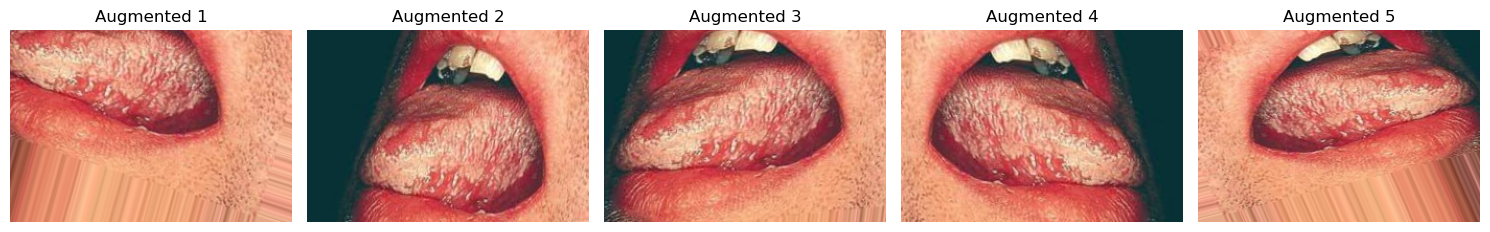

In [15]:
image_path = './oral_cancer_train_test_split/train/oral_cancer/oral_cancer.73.jpg'
image = load_img(image_path)  
image = img_to_array(image)   
image = np.expand_dims(image, axis=0)  

aug_iter = train_datagen.flow(image, batch_size=1)

fig, axes = plt.subplots(1, 5, figsize=(15, 15))
for i in range(5):
    batch = next(aug_iter)
    ax = axes[i]
    img = batch[0]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Augmented {i+1}')

plt.tight_layout()
plt.show()

In [3]:
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
        'oral_cancer_train_test_split/train/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

validation_data = test_datagen.flow_from_directory(
        'oral_cancer_train_test_split/test/',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical')

Found 685 images belonging to 3 classes.
Found 173 images belonging to 3 classes.


## Evaluation Functions

### Evaluate model

In [4]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, validation_data):
    
    test_loss, test_accuracy = model.evaluate(validation_data)
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

    y_pred = model.predict(validation_data)
    y_pred_classes = np.argmax(y_pred, axis=1)

    y_true = validation_data.classes
    class_labels = list(validation_data.class_indices.keys())
    
    print(classification_report(y_true, y_pred_classes, target_names=class_labels))

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(4, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix")
    plt.ylabel("True Labels")
    plt.xlabel("Predicted Labels")
    plt.show()

### Prediction

In [5]:
from keras.utils import load_img, img_to_array

def load_and_preprocess_image(img_path):
        """Load and preprocess a single image."""
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        return np.expand_dims(img_array, axis=0)

def display_model_predictions(model, root_dir='./oral_cancer_train_test_split/test',
                                    class_names=['normal', 'oral_cancer', 'pre_cancer'],
                                    num_images=5, display_image=False):
    '''Custom function to display model predictions'''

    def load_images_from_class(class_dir, class_label, num_images):
        """Load a specified number of images from a given class directory."""
        images = []
        img_files = random.sample(os.listdir(class_dir), num_images)
        for img_file in img_files:
            img_path = os.path.join(class_dir, img_file)
            img_array = load_and_preprocess_image(img_path)
            images.append((img_path, img_array, class_label))
        return images

    def load_images_from_all_classes(root_dir, class_names, num_images):
        """Load images from all specified classes in the root directory."""
        all_images = []
        for class_name in class_names:
            class_dir = os.path.join(root_dir, class_name)
            all_images.extend(load_images_from_class(class_dir, class_name, num_images))
        return all_images

    def predict_images(model, images, class_map):
        """Make predictions on a list of images using the provided model."""
        predictions = []
        for img_path, img_array, true_class in images:
            pred = model.predict(img_array)
            pred_class_idx = np.argmax(pred, axis=1)[0]
            predictions.append((img_path, true_class, class_map[pred_class_idx], np.max(pred, axis=1)[0]))
        return predictions

    def display_images_with_predictions(images, predictions, class_map):
        """Display images with their true and predicted classes."""
        plt.figure(figsize=(15, 10))
        num_images = len(predictions)
        cols = 5
        rows = (num_images // cols) + (num_images % cols > 0)
        for i, (img_path, true_class, pred_class) in enumerate(predictions):
            img = image.load_img(img_path, target_size=(224, 224))  
            plt.subplot(3, 5, i + 1) 
            plt.imshow(img)
            plt.title(f'True: {true_class}\nPred: {pred_class}') 
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    all_images = load_images_from_all_classes(root_dir, class_names, num_images)
    
    class_map = {0: 'normal', 1: 'oral_cancer', 2: 'pre_cancer'}

    predictions = predict_images(model, all_images, class_map)

    for img_path, true_class, pred_class, confidence in predictions:
        print(f"Image: {os.path.basename(img_path)} - True Class: {true_class}, Predicted Class: {pred_class}")
    
    if display_image:
        display_images_with_predictions(all_images, predictions, class_map)

## CNN with Data Augmentation

In [11]:
# custom CNN model

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

def create_model():
    model = keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Conv2D(512, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

custom_cnn_model = create_model()
custom_cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 10, 10, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,258,755 (31.50 MB)

 Trainable params: 8,256,771 (31.50 MB)

 Non-trainable params: 1,984 (7.75 KB)

In [13]:
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="custom_cnn.keras", save_best_only=True, monitor="val_loss") ]

history = custom_cnn_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.5945 - loss: 0.7716 - val_accuracy: 0.3121 - val_loss: 6.1619
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6118 - loss: 0.7963 - val_accuracy: 0.3121 - val_loss: 7.1792
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6240 - loss: 0.7956 - val_accuracy: 0.3295 - val_loss: 6.1772
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - accuracy: 0.5700 - loss: 0.7408 - val_accuracy: 0.3468 - val_loss: 5.5907
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.6064 - loss: 0.7589 - val_accuracy: 0.3642 - val_loss: 3.4290
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6202 - loss: 0.7269 - val_accuracy: 0.3988 - val_loss: 2.9322
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.6325 - loss: 0.7457 - val_accuracy: 0.3931 - val_loss: 3.3590
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.5857 - loss: 0.7653 - val_accuracy: 0.4335 - val_loss:

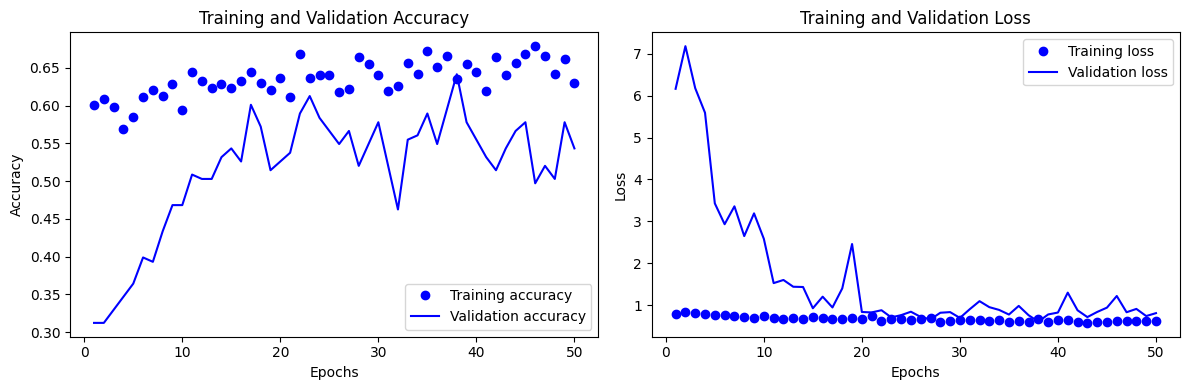

In [17]:
plot_training_history(history)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.5663 - loss: 0.8237
Test Accuracy: 0.5434
Test Loss: 0.8133
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step
              precision    recall  f1-score   support

      normal       0.24      0.17      0.20        53
 oral_cancer       0.29      0.33      0.31        57
  pre_cancer       0.38      0.41      0.39        63

    accuracy                           0.31       173
   macro avg       0.30      0.31      0.30       173
weighted avg       0.30      0.31      0.31       173



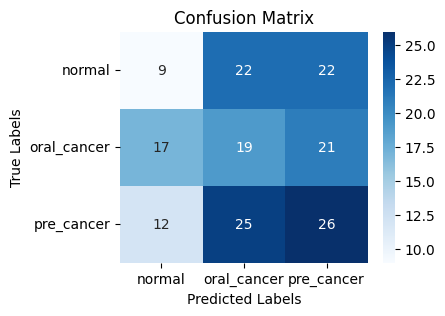

In [14]:
evaluate_model(custom_cnn_model, validation_data)

In [18]:
display_model_predictions(custom_cnn_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Image: normal.248.jpeg - True Class: normal, Predicted Class: normal
Image: normal.229.jpeg - True Class: normal, Predicted Class: oral_cancer
Image: normal.257.jpeg - True Class: normal, Predicted Class: normal
Image: normal.259.jpeg - True Class: normal, Predicted Class: normal
Image: normal.255.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.262.jpg - True Class: oral_cancer, Predicted Class:

## Pre-trained Models

### ResNet101

In [7]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x)
predictions = Dense(3, activation='softmax')(x)

resnet_model = Model(inputs=base_model.input, outputs=predictions)

resnet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# resnet_model.summary()

In [29]:
# train resnet
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="resnet.keras", save_best_only=True, monitor="val_loss") ]

history = resnet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

In [ ]:
history = np.load('resnet_history.npy',allow_pickle='TRUE').item()

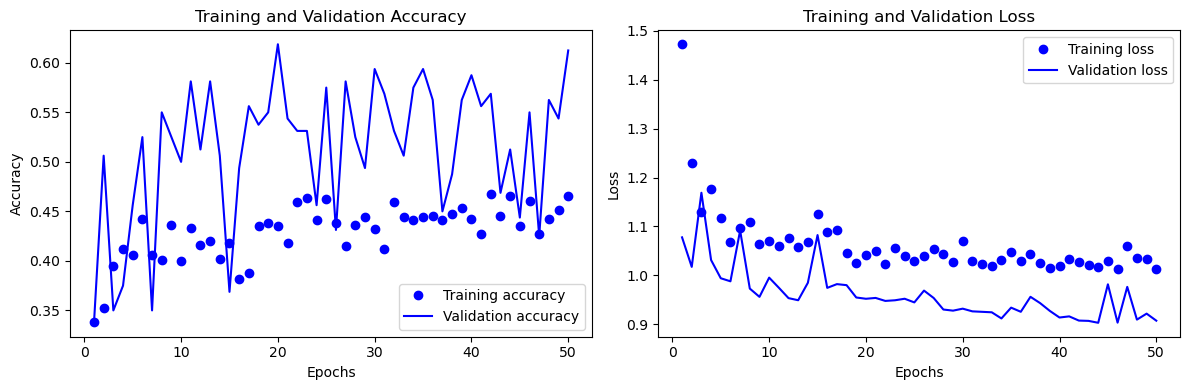

In [38]:
plot_training_history(history)

In [41]:
resnet_model = keras.models.load_model("resnet.keras")
test_loss, test_acc = resnet_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 30s 4s/step - loss: 0.9057 - accuracy: 0.5029
Test accuracy: 0.503


6/6 [==============================] - 35s 6s/step - loss: 0.9057 - accuracy: 0.5029
Test Accuracy: 0.5029
Test Loss: 0.9057
6/6 [==============================] - 31s 5s/step
              precision    recall  f1-score   support

      normal       0.29      0.49      0.36        53
 oral_cancer       0.41      0.12      0.19        57
  pre_cancer       0.32      0.33      0.33        63

    accuracy                           0.31       173
   macro avg       0.34      0.32      0.29       173
weighted avg       0.34      0.31      0.29       173



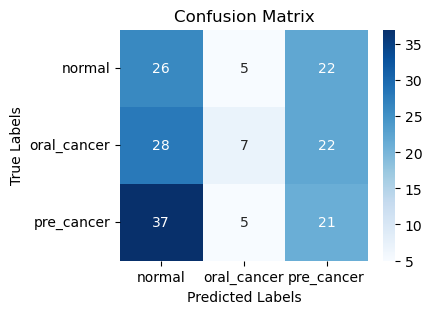

In [42]:
evaluate_model(resnet_model, validation_data)

In [56]:
display_model_predictions(resnet_model)

1/1 [==============================] - 0s 180ms/step
Image: normal.255.jpeg - True Class: normal, Predicted Class: normal
Image: normal.218.jpeg - True Class: normal, Predicted Class: normal
Image: normal.230.jpeg - True Class: normal, Predicted Class: normal
Image: normal.242.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.241.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.263.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.246.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.248.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.233.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.300.jpg - True Class: pre_cancer, Predicted Class: normal
Image: pre_cancer.303.jpeg - True Class: pre_cancer, Predicted Class: normal
Image: pre_cancer.289.png - True Class: pre_cancer

### VGG16

In [24]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg16_model = Model(inputs=base_model.input, outputs=predictions)

vgg16_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

vgg16_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,243,075 (58.15 MB)

 Trainable params: 528,387 (2.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [29]:
# train vgg16
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16.keras", save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

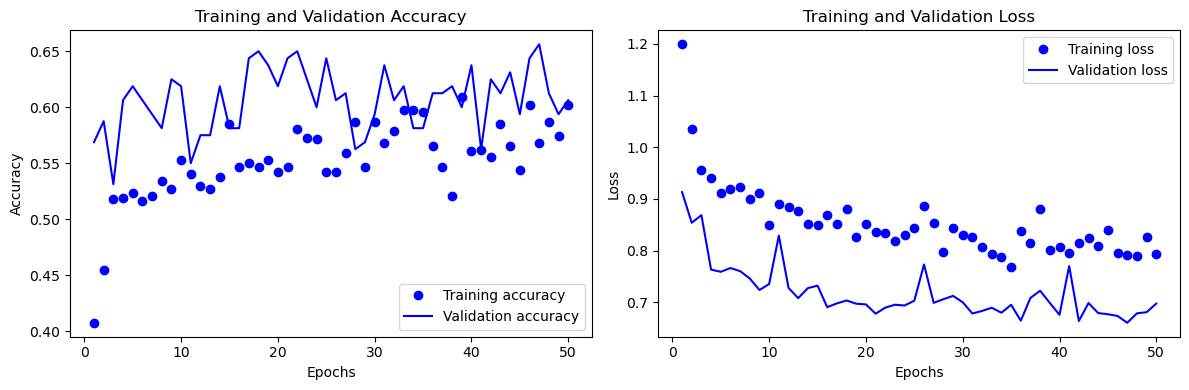

In [35]:
plot_training_history(history)

In [53]:
vgg16_model = keras.models.load_model("vgg16.keras")
test_loss, test_acc = vgg16_model.evaluate(validation_data)
print(f"Test accuracy: {test_acc:.3f}")

6/6 [==============================] - 49s 8s/step - loss: 0.6682 - accuracy: 0.6474
Test accuracy: 0.647


6/6 [==============================] - 49s 8s/step - loss: 0.6682 - accuracy: 0.6474
Test Accuracy: 0.6474
Test Loss: 0.6682
6/6 [==============================] - 50s 8s/step
              precision    recall  f1-score   support

      normal       0.33      0.34      0.33        53
 oral_cancer       0.18      0.05      0.08        57
  pre_cancer       0.38      0.60      0.46        63

    accuracy                           0.34       173
   macro avg       0.29      0.33      0.29       173
weighted avg       0.30      0.34      0.30       173



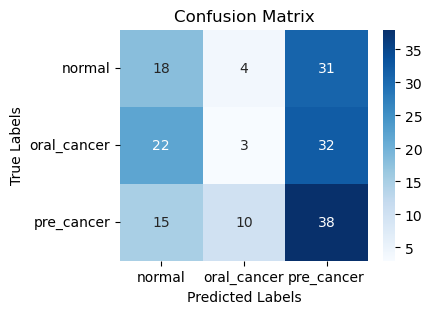

In [54]:
evaluate_model(vgg16_model, validation_data)

In [58]:
display_model_predictions(vgg16_model)

1/1 [==============================] - 0s 281ms/step
Image: normal.252.jpeg - True Class: normal, Predicted Class: normal
Image: normal.240.jpeg - True Class: normal, Predicted Class: normal
Image: normal.254.jpeg - True Class: normal, Predicted Class: normal
Image: normal.262.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.275.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.268.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.280.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.232.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.278.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.278.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.250.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.293.jpg - Tru

In [60]:
# unfreeze top layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-4]:
    layer.trainable = False

In [29]:
# fine-tuning
vgg16_model = keras.models.load_model("vgg16.keras")
vgg16_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg16_finetuned.keras", 
                                              save_best_only=True, monitor="val_loss") ]

history = vgg16_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

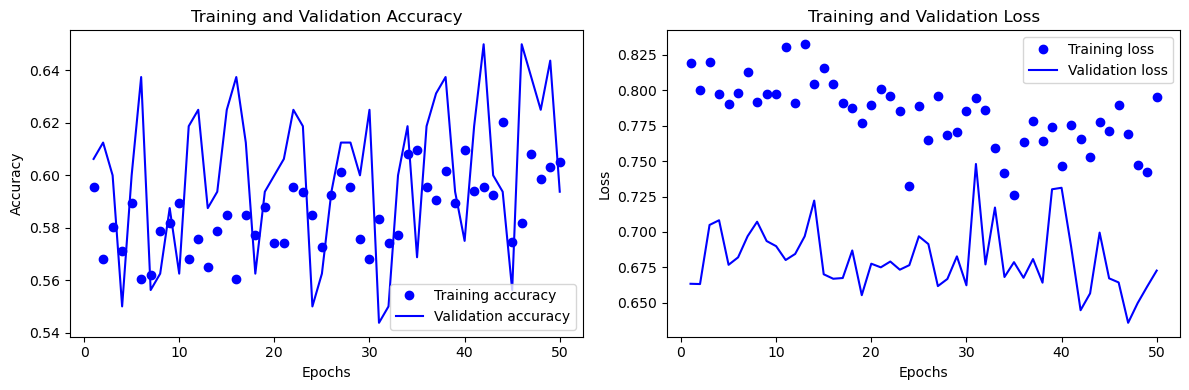

In [51]:
plot_training_history(history)

In [61]:
vgg16_finetuned_model = keras.models.load_model("vgg16_finetuned.keras")

6/6 [==============================] - 50s 8s/step - loss: 0.6579 - accuracy: 0.6127
Test Accuracy: 0.6127
Test Loss: 0.6579
6/6 [==============================] - 65s 10s/step
              precision    recall  f1-score   support

      normal       0.37      0.42      0.39        53
 oral_cancer       0.30      0.25      0.27        57
  pre_cancer       0.38      0.40      0.39        63

    accuracy                           0.35       173
   macro avg       0.35      0.35      0.35       173
weighted avg       0.35      0.35      0.35       173



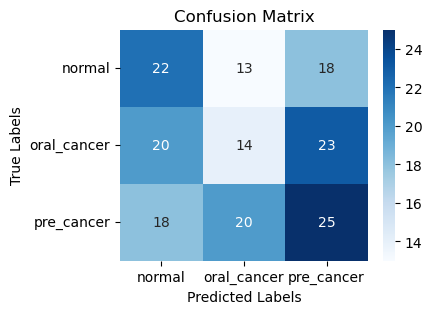

In [63]:
evaluate_model(vgg16_finetuned_model, validation_data)

In [65]:
display_model_predictions(vgg16_finetuned_model)

1/1 [==============================] - 0s 339ms/step
Image: normal.264.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: normal.244.jpeg - True Class: normal, Predicted Class: normal
Image: normal.258.jpeg - True Class: normal, Predicted Class: normal
Image: normal.229.jpeg - True Class: normal, Predicted Class: normal
Image: normal.215.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.246.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: oral_cancer.243.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.279.jpg - True Class: oral_cancer, Predicted Class: normal
Image: oral_cancer.234.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.240.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.282.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.279.jpg - True Class: pre_cancer, Predicted Class: oral_cancer
Image: pre_cancer.269.jpg - Tr

### VGG19

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

vgg19_model = Model(inputs=base_model.input, outputs=predictions)

vgg19_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# vgg19_model.summary()

In [ ]:
# train vgg19
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="vgg19.keras", save_best_only=True, monitor="val_loss") ]

history = vgg19_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

In [86]:
vgg19_model = keras.models.load_model("vgg19.keras")

6/6 [==============================] - 59s 10s/step - loss: 1.0694 - accuracy: 0.3295
Test Accuracy: 0.3295
Test Loss: 1.0694
6/6 [==============================] - 66s 11s/step
              precision    recall  f1-score   support

      normal       1.00      0.04      0.07        53
 oral_cancer       0.34      0.98      0.51        57
  pre_cancer       0.43      0.05      0.09        63

    accuracy                           0.35       173
   macro avg       0.59      0.36      0.22       173
weighted avg       0.57      0.35      0.22       173



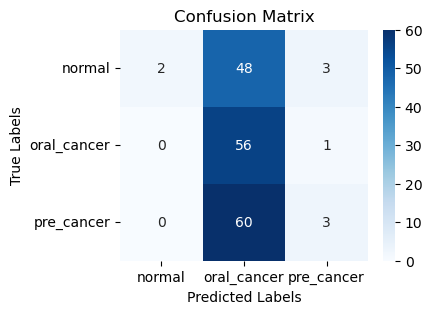

In [87]:
evaluate_model(vgg19_model, validation_data)

### InceptionV3

In [12]:
from keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(1024, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

inceptionv3_model = Model(inputs=base_model.input, outputs=predictions)

inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# inceptionv3_model.summary()

In [ ]:
# train inceptionv3
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

In [ ]:
# fine-tuning
# freeze the first 249 layers and unfreeze the rest
for layer in base_model.layers[:310]:
    layer.trainable = False
for layer in base_model.layers[310:]:
    layer.trainable = True
    
inceptionv3_model = keras.models.load_model("inceptionv3.keras")
inceptionv3_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="inceptionv3.keras", save_best_only=True, monitor="val_loss") ]

history = inceptionv3_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

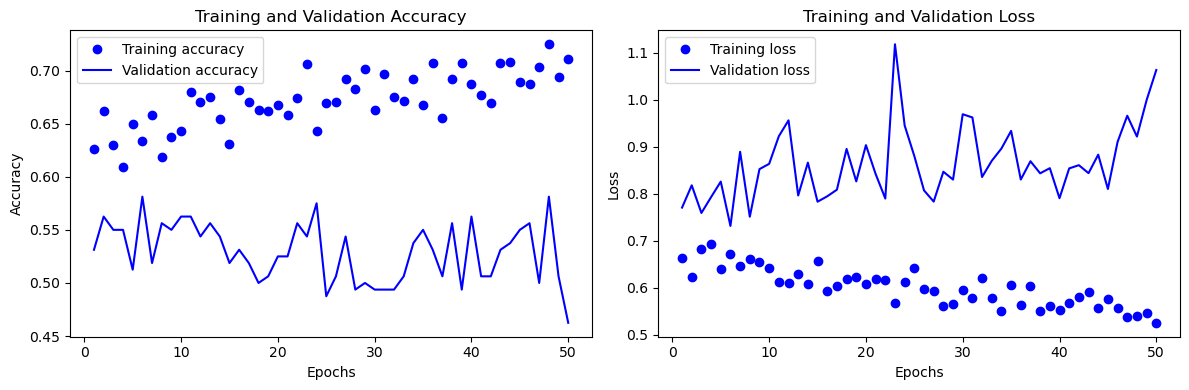

In [67]:
plot_training_history(history)

In [68]:
inceptionv3_model = keras.models.load_model("inceptionv3.keras")

6/6 [==============================] - 11s 1s/step - loss: 0.7369 - accuracy: 0.5780
Test Accuracy: 0.5780
Test Loss: 0.7369
6/6 [==============================] - 10s 1s/step
              precision    recall  f1-score   support

      normal       0.26      0.23      0.24        53
 oral_cancer       0.40      0.07      0.12        57
  pre_cancer       0.37      0.68      0.48        63

    accuracy                           0.34       173
   macro avg       0.34      0.33      0.28       173
weighted avg       0.35      0.34      0.29       173



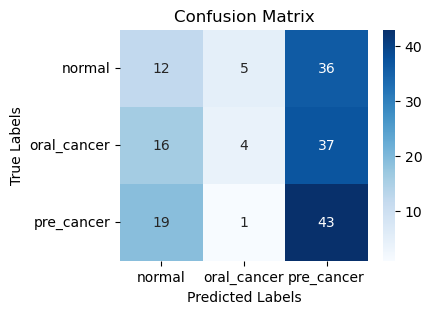

In [69]:
evaluate_model(inceptionv3_model, validation_data)

In [71]:
display_model_predictions(inceptionv3_model)

1/1 [==============================] - 0s 73ms/step
Image: normal.258.jpeg - True Class: normal, Predicted Class: normal
Image: normal.225.jpeg - True Class: normal, Predicted Class: normal
Image: normal.263.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: normal.229.jpeg - True Class: normal, Predicted Class: normal
Image: normal.247.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.236.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.275.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.246.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.270.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.232.jpg - True Class: oral_cancer, Predicted Class: oral_cancer
Image: pre_cancer.297.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.258.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.262.jp

### DenseNet121

In [10]:
from tensorflow.keras.applications import DenseNet121

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dropout(0.5)(x)  
x = Dense(1024, activation='relu')(x)  
predictions = Dense(3, activation='softmax')(x)

densenet_model = Model(inputs=base_model.input, outputs=predictions)

densenet_model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
callbacks = [ keras.callbacks.ModelCheckpoint( filepath="densenet.keras", save_best_only=True, monitor="val_loss") ]

history = densenet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size,
    callbacks=callbacks
)

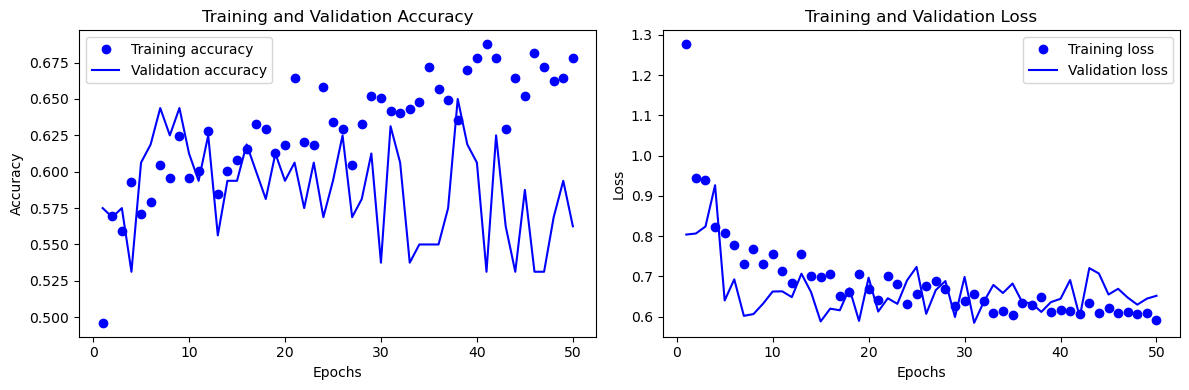

In [74]:
plot_training_history(history)

In [75]:
densenet_model = keras.models.load_model("densenet.keras")

6/6 [==============================] - 16s 2s/step - loss: 0.5866 - accuracy: 0.6358
Test Accuracy: 0.6358
Test Loss: 0.5866
6/6 [==============================] - 14s 2s/step
              precision    recall  f1-score   support

      normal       0.32      0.30      0.31        53
 oral_cancer       0.44      0.07      0.12        57
  pre_cancer       0.39      0.70      0.50        63

    accuracy                           0.37       173
   macro avg       0.38      0.36      0.31       173
weighted avg       0.39      0.37      0.32       173



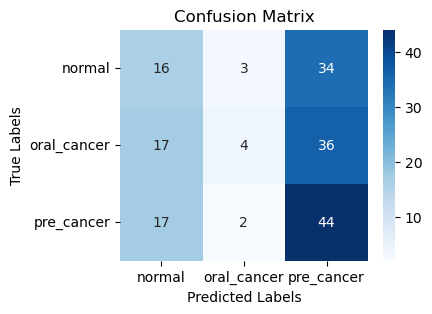

In [76]:
evaluate_model(densenet_model, validation_data)

In [78]:
display_model_predictions(densenet_model)

1/1 [==============================] - 0s 96ms/step
Image: normal.246.jpeg - True Class: normal, Predicted Class: normal
Image: normal.257.jpeg - True Class: normal, Predicted Class: normal
Image: normal.221.jpeg - True Class: normal, Predicted Class: normal
Image: normal.214.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: oral_cancer.231.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.241.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.232.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.248.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.265.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.297.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.273.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.286.jpg - True 

In [ ]:
# finetune
# freeze first 141 layers and unfreeze the rest
for layer in base_model.layers[:141]:
    layer.trainable = False
for layer in base_model.layers[141:]:
    layer.trainable = True
    
densenet_model = keras.models.load_model("densenet.keras")
    
densenet_model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

callbacks = [ keras.callbacks.ModelCheckpoint( filepath="densenet_finetuned.keras", save_best_only=True, monitor="val_loss") ]

history_finetuned = densenet_model.fit(
    train_data,
    validation_data=validation_data,
    epochs=50,
    steps_per_epoch=train_data.samples // train_data.batch_size,
    validation_steps=validation_data.samples // validation_data.batch_size
)

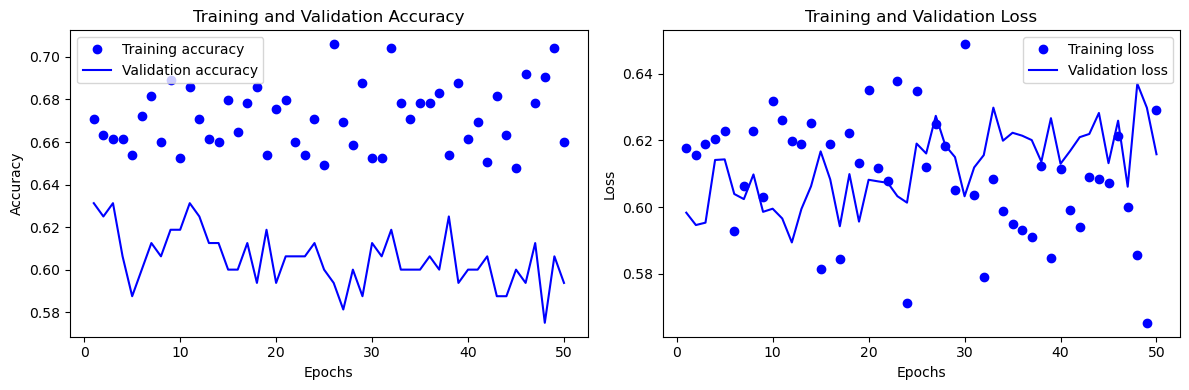

In [80]:
plot_training_history(history)

In [81]:
densenet_finetuned_model = keras.models.load_model("densenet.keras")

6/6 [==============================] - 15s 2s/step - loss: 0.5866 - accuracy: 0.6358
Test Accuracy: 0.6358
Test Loss: 0.5866
6/6 [==============================] - 14s 2s/step
              precision    recall  f1-score   support

      normal       0.30      0.28      0.29        53
 oral_cancer       0.56      0.09      0.15        57
  pre_cancer       0.37      0.67      0.47        63

    accuracy                           0.36       173
   macro avg       0.41      0.35      0.31       173
weighted avg       0.41      0.36      0.31       173



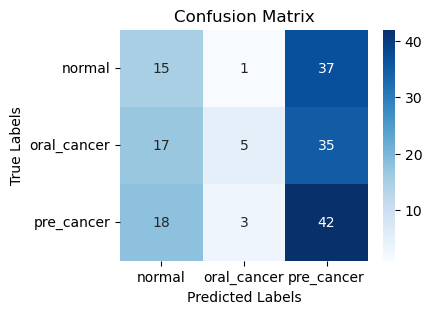

In [82]:
evaluate_model(densenet_finetuned_model, validation_data)

In [84]:
display_model_predictions(densenet_finetuned_model)

1/1 [==============================] - 0s 94ms/step
Image: normal.228.jpeg - True Class: normal, Predicted Class: normal
Image: normal.215.jpeg - True Class: normal, Predicted Class: normal
Image: normal.238.jpeg - True Class: normal, Predicted Class: normal
Image: normal.256.jpeg - True Class: normal, Predicted Class: normal
Image: normal.252.jpeg - True Class: normal, Predicted Class: pre_cancer
Image: oral_cancer.275.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.227.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.252.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.268.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: oral_cancer.230.jpg - True Class: oral_cancer, Predicted Class: pre_cancer
Image: pre_cancer.287.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.277.jpg - True Class: pre_cancer, Predicted Class: pre_cancer
Image: pre_cancer.276.jpg - T

## Convert model to tflite

In [22]:
import tensorflow as tf

model = keras.models.load_model('vgg16_finetuned.keras')

# convert
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# save tflite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpirh61ij8/assets


INFO:tensorflow:Assets written to: /tmp/tmpirh61ij8/assets
2024-09-26 11:28:44.389552: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-09-26 11:28:44.389611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-09-26 11:28:44.390432: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpirh61ij8
2024-09-26 11:28:44.396388: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-09-26 11:28:44.396424: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpirh61ij8
2024-09-26 11:28:44.409121: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-09-26 11:28:44.413124: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-09-26 11:28:44.544804: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio